In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from descartes import PolygonPatch
import matplotlib.gridspec as gridspec
from matplotlib import rc

import osmnx as ox
import networkx as nx

In [2]:
style.use('seaborn-white')
output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [3]:
output_folder = 'data'
output_sub_folder_utrecht = 'Utrecht_19Dec2022'
output_sub_folder_milano = 'Milano_19Dec2022'
output_sub_folder_ljubljana = 'Ljubljana_19Dec2022'

crs_milano = 'EPSG:6875'
crs_ljubljana = 'EPSG:8687'
crs_utrecht = 'EPSG:28992'

In [4]:
trip_distances = [300]
buffer = max(trip_distances)

green = '#238443'
trip_colors_green = ['#78c679']   # #c2e699 ffffcc
orange = '#cc4c02'
trip_colors_orange = ['#fe9929']   # #fed98e ffffd4

# Load data

In [5]:
xmin = 1022678.517
ymin = 5695916.600
xmax = 1027342.347
ymax = 5698126.489

pointList = [Point(xmin, ymin), Point(xmax, ymin), Point(xmax, ymax), Point(xmin, ymax), Point(xmin, ymin)]
bbox_shape = Polygon([[p.x, p.y] for p in pointList])

place_milano = gpd.GeoDataFrame(index=[0], crs='epsg:3857', geometry=[bbox_shape]).to_crs(crs_milano)

In [6]:
xmin =  1612551.082
ymin =  5787620.135
xmax =  1617214.912
ymax =  5789830.024

pointList = [Point(xmin, ymin), Point(xmax, ymin), Point(xmax, ymax), Point(xmin, ymax), Point(xmin, ymin)]
bbox_shape = Polygon([[p.x, p.y] for p in pointList])

place_ljubljana = gpd.GeoDataFrame(index=[0], crs='epsg:3857', geometry=[bbox_shape]).to_crs(crs_ljubljana)

In [7]:
xmin =  564607.450
ymin =  6815369.636
xmax =  569271.280
ymax =  6817579.525

pointList = [Point(xmin, ymin), Point(xmax, ymin), Point(xmax, ymax), Point(xmin, ymax), Point(xmin, ymin)]
bbox_shape = Polygon([[p.x, p.y] for p in pointList])

place_utrecht = gpd.GeoDataFrame(index=[0], crs='epsg:3857', geometry=[bbox_shape]).to_crs(crs_utrecht)

### Utrecht

In [8]:
barrier_list_utrecht = [
    gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'highway_speed_barrier_50.geojson')).set_crs(crs_utrecht),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'highway_speed_barrier_60more.geojson')).set_crs(crs_utrecht),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'highway_type_barrier_major.geojson')).set_crs(crs_utrecht),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'highway_type_barrier_12.geojson')).set_crs(crs_utrecht),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'highway_type_barrier_3.geojson')).set_crs(crs_utrecht),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'railway_barrier_tram.geojson')).set_crs(crs_utrecht),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'railway_barrier_other.geojson')).set_crs(crs_utrecht),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'natural_barrier_blue.geojson')).set_crs(crs_utrecht),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'natural_barrier_parks_large.geojson')).set_crs(crs_utrecht)
]

In [9]:
all_barriers_utrecht = pd.concat(barrier_list_utrecht)
all_barriers_utrecht.reset_index(drop=True, inplace=True)

In [10]:
safe_crossings_utrecht = gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'safe_crossings.geojson')).set_crs(crs_utrecht)

In [11]:
playground_attraction_utrecht = gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'playground_attraction.geojson')).set_crs(crs_utrecht)
schoolyard_attraction_utrecht = gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'schoolyard_attraction.geojson')).set_crs(crs_utrecht, allow_override=True)
small_park_attraction_utrecht = gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'small_park_attraction.geojson')).set_crs(crs_utrecht)

In [12]:
paths_utrecht = gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'paths.geojson')).set_crs(crs_utrecht)

In [13]:
playground_euclidean_access_utrecht = gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'playground_euclidean_access.geojson')).set_crs(crs_utrecht)

playground_network_access_utrecht = gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'playground_network_access.geojson')).set_crs(crs_utrecht)

schoolyard_network_access_utrecht = gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'schoolyard_network_access.geojson')).set_crs(crs_utrecht)
small_park_network_access_utrecht = gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'small_park_network_access.geojson')).set_crs(crs_utrecht)

playground_childsplay_access_utrecht = gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'playground_childsplay_access.geojson')).set_crs(crs_utrecht)
schoolyard_childsplay_access_utrecht = gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'schoolyard_childsplay_access.geojson')).set_crs(crs_utrecht)
small_park_childsplay_access_utrecht = gpd.read_file(os.path.join(output_folder, output_sub_folder_utrecht, 'small_park_childsplay_access.geojson')).set_crs(crs_utrecht)

#### population data

In [14]:
population_nl = gpd.read_file(os.path.join(output_folder, 'CBS100m/cbs_vk100_2021_v1.gpkg'))
col_cld = 'aantal_inwoners_0_tot_15_jaar'
nan_val = -99997

population_nl = population_nl.set_geometry(population_nl.centroid)
population_utrecht = gpd.clip(population_nl, place_utrecht)
population_utrecht = population_utrecht.replace({col_cld: nan_val}, value=0)

### Milano

In [15]:
barrier_list_milano = [
    gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'highway_speed_barrier_50.geojson')).set_crs(crs_milano),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'highway_type_barrier_12.geojson')).set_crs(crs_milano),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'highway_type_barrier_3.geojson')).set_crs(crs_milano),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'railway_barrier_tram.geojson')).set_crs(crs_milano),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'railway_barrier_other.geojson')).set_crs(crs_milano),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'natural_barrier_blue.geojson')).set_crs(crs_milano),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'natural_barrier_parks_large.geojson')).set_crs(crs_milano)
]

In [16]:
all_barriers_milano = pd.concat(barrier_list_milano)
all_barriers_milano.reset_index(drop=True, inplace=True)

In [17]:
safe_crossings_milano = gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'safe_crossings.geojson')).set_crs(crs_milano)

In [18]:
playground_attraction_milano = gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'playground_attraction.geojson')).set_crs(crs_milano)
schoolyard_attraction_milano = gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'schoolyard_attraction.geojson')).set_crs(crs_milano, allow_override=True)
small_park_attraction_milano = gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'small_park_attraction.geojson')).set_crs(crs_milano)

In [19]:
paths_milano = gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'paths.geojson')).set_crs(crs_milano)

In [20]:
playground_euclidean_access_milano = gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'playground_euclidean_access.geojson')).set_crs(crs_milano)

playground_network_access_milano = gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'playground_network_access.geojson')).set_crs(crs_milano)

schoolyard_network_access_milano = gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'schoolyard_network_access.geojson')).set_crs(crs_milano)
small_park_network_access_milano = gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'small_park_network_access.geojson')).set_crs(crs_milano)

playground_childsplay_access_milano = gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'playground_childsplay_access.geojson')).set_crs(crs_milano)
schoolyard_childsplay_access_milano = gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'schoolyard_childsplay_access.geojson')).set_crs(crs_milano)
small_park_childsplay_access_milano = gpd.read_file(os.path.join(output_folder, output_sub_folder_milano, 'small_park_childsplay_access.geojson')).set_crs(crs_milano)

### Ljubljana

In [21]:
barrier_list_ljubljana = [
    gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'highway_speed_barrier_50.geojson')).set_crs(crs_ljubljana),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'highway_speed_barrier_60more.geojson')).set_crs(crs_ljubljana),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'highway_type_barrier_12.geojson')).set_crs(crs_ljubljana),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'highway_type_barrier_3.geojson')).set_crs(crs_ljubljana),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'railway_barrier_other.geojson')).set_crs(crs_ljubljana),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'natural_barrier_blue.geojson')).set_crs(crs_ljubljana),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'natural_barrier_parks_large.geojson')).set_crs(crs_ljubljana),
    gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'natural_barrier_green_large.geojson')).set_crs(crs_ljubljana)
]

In [22]:
all_barriers_ljubljana = pd.concat(barrier_list_ljubljana)
all_barriers_ljubljana.reset_index(drop=True, inplace=True)

In [23]:
safe_crossings_ljubljana = gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'safe_crossings.geojson')).set_crs(crs_ljubljana)

In [24]:
playground_attraction_ljubljana = gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'playground_attraction.geojson')).set_crs(crs_ljubljana)
schoolyard_attraction_ljubljana = gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'schoolyard_attraction.geojson')).set_crs(crs_ljubljana, allow_override=True)
small_park_attraction_ljubljana = gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'small_park_attraction.geojson')).set_crs(crs_ljubljana)

In [25]:
paths_ljubljana = gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'paths.geojson')).set_crs(crs_ljubljana)

In [26]:
playground_euclidean_access_ljubljana = gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'playground_euclidean_access.geojson')).set_crs(crs_ljubljana)

playground_network_access_ljubljana = gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'playground_network_access.geojson')).set_crs(crs_ljubljana)

schoolyard_network_access_ljubljana = gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'schoolyard_network_access.geojson')).set_crs(crs_ljubljana)
small_park_network_access_ljubljana = gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'small_park_network_access.geojson')).set_crs(crs_ljubljana)

playground_childsplay_access_ljubljana = gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'playground_childsplay_access.geojson')).set_crs(crs_ljubljana)
schoolyard_childsplay_access_ljubljana = gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'schoolyard_childsplay_access.geojson')).set_crs(crs_ljubljana)
small_park_childsplay_access_ljubljana = gpd.read_file(os.path.join(output_folder, output_sub_folder_ljubljana, 'small_park_childsplay_access.geojson')).set_crs(crs_ljubljana)

### Account for safe crossings: pedestrian bridges and tunnels

In [27]:
# excluding safe crossings from barriers
all_barriers_nosafecrossing_utrecht = gpd.GeoDataFrame(
    all_barriers_utrecht.unary_union.difference(safe_crossings_utrecht.unary_union)).rename(
    columns={0:'geometry'}).set_geometry('geometry').set_crs(crs_utrecht)

In [28]:
# excluding safe crossings from barriers
all_barriers_nosafecrossing_milano = gpd.GeoDataFrame(
    all_barriers_milano.unary_union.difference(safe_crossings_milano.unary_union)).rename(
    columns={0:'geometry'}).set_geometry('geometry').set_crs(crs_milano)

In [29]:
# excluding safe crossings from barriers
all_barriers_nosafecrossing_ljubljana = gpd.GeoDataFrame(
    all_barriers_ljubljana.unary_union.difference(safe_crossings_ljubljana.unary_union)).rename(
    columns={0:'geometry'}).set_geometry('geometry').set_crs(crs_ljubljana)

## Set Geometry types

In [30]:
def set_types_geometries(df, cols, crs):
    for col in cols:
        df[col] = gpd.GeoSeries.from_wkt(df[col])
        gdf = gpd.GeoDataFrame(df, geometry=col).set_crs(crs)

In [31]:
cols = []
for trip_dist in trip_distances:
    cols.append('geom_eucl_'+str(trip_dist))
    
set_types_geometries(playground_euclidean_access_utrecht, cols, crs_utrecht)
set_types_geometries(playground_euclidean_access_milano, cols, crs_milano)
set_types_geometries(playground_euclidean_access_ljubljana, cols, crs_ljubljana)

In [32]:
cols = []
for trip_dist in trip_distances:
    cols.append('geom_iso_'+str(trip_dist))
    
set_types_geometries(playground_network_access_utrecht, cols, crs_utrecht)
set_types_geometries(schoolyard_network_access_utrecht, cols, crs_utrecht)
set_types_geometries(small_park_network_access_utrecht, cols, crs_utrecht)
set_types_geometries(playground_childsplay_access_utrecht, cols, crs_utrecht)
set_types_geometries(schoolyard_childsplay_access_utrecht, cols, crs_utrecht)
set_types_geometries(small_park_childsplay_access_utrecht, cols, crs_utrecht)

set_types_geometries(playground_network_access_milano, cols, crs_milano)
set_types_geometries(schoolyard_network_access_milano, cols, crs_milano)
set_types_geometries(small_park_network_access_milano, cols, crs_milano)
set_types_geometries(playground_childsplay_access_milano, cols, crs_milano)
set_types_geometries(schoolyard_childsplay_access_milano, cols, crs_milano)
set_types_geometries(small_park_childsplay_access_milano, cols, crs_milano)

set_types_geometries(playground_network_access_ljubljana, cols, crs_ljubljana)
set_types_geometries(schoolyard_network_access_ljubljana, cols, crs_ljubljana)
set_types_geometries(small_park_network_access_ljubljana, cols, crs_ljubljana)
set_types_geometries(playground_childsplay_access_ljubljana, cols, crs_ljubljana)
set_types_geometries(schoolyard_childsplay_access_ljubljana, cols, crs_ljubljana)
set_types_geometries(small_park_childsplay_access_ljubljana, cols, crs_ljubljana)

## Calculate children having access in Utrecht case study area

In [33]:
cld_total_utrecht = population_utrecht[col_cld].sum()
cld_total_utrecht

4500

<AxesSubplot:>

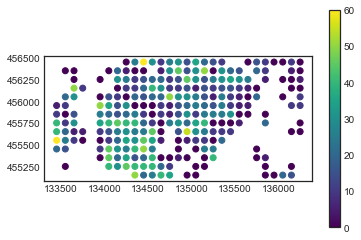

In [34]:
population_utrecht.plot(column=col_cld, cmap='viridis', legend=True)

In [35]:
eucl_area = gpd.GeoDataFrame(playground_euclidean_access_utrecht.geom_eucl_300.geometry.unary_union).rename(columns={0:'geometry'}).set_geometry('geometry').set_crs(crs_utrecht)
population_utrecht_eucl_access = gpd.clip(population_utrecht, eucl_area)
cld_eucl_access_utrecht = population_utrecht_eucl_access[col_cld].sum()
cld_eucl_access_utrecht = str(int(round(cld_eucl_access_utrecht/cld_total_utrecht, 2)*100))
cld_eucl_access_utrecht

'90'

In [36]:
netw_area = gpd.GeoDataFrame(playground_network_access_utrecht.geom_iso_300.geometry.unary_union).rename(columns={0:'geometry'}).set_geometry('geometry').set_crs(crs_utrecht)
population_utrecht_netw_access = gpd.clip(population_utrecht, netw_area)
cld_netw_access_utrecht = population_utrecht_netw_access[col_cld].sum()
cld_netw_access_utrecht = str(int(round(cld_netw_access_utrecht/cld_total_utrecht, 2)*100))
cld_netw_access_utrecht

'79'

In [37]:
range_area = pd.concat([playground_network_access_utrecht, schoolyard_network_access_utrecht, small_park_network_access_utrecht])
range_area = gpd.GeoDataFrame(range_area.geom_iso_300.geometry.unary_union).rename(columns={0:'geometry'}).set_geometry('geometry').set_crs(crs_utrecht)
population_utrecht_range_access = gpd.clip(population_utrecht, range_area)
cld_range_access_utrecht = population_utrecht_range_access[col_cld].sum()
cld_range_access_utrecht = str(int(round(cld_range_access_utrecht/cld_total_utrecht, 2)*100))
cld_range_access_utrecht

'94'

In [38]:
childsplay_area = pd.concat([playground_childsplay_access_utrecht, schoolyard_childsplay_access_utrecht, small_park_childsplay_access_utrecht])
childsplay_area = gpd.GeoDataFrame(childsplay_area.geom_iso_300.geometry.unary_union).rename(columns={0:'geometry'}).set_geometry('geometry').set_crs(crs_utrecht)
population_utrecht_childsplay_access = gpd.clip(population_utrecht, childsplay_area)
cld_childsplay_access_utrecht = population_utrecht_childsplay_access[col_cld].sum()
cld_childsplay_access_utrecht = str(int(round(cld_childsplay_access_utrecht/cld_total_utrecht, 2)*100))
cld_childsplay_access_utrecht

'81'

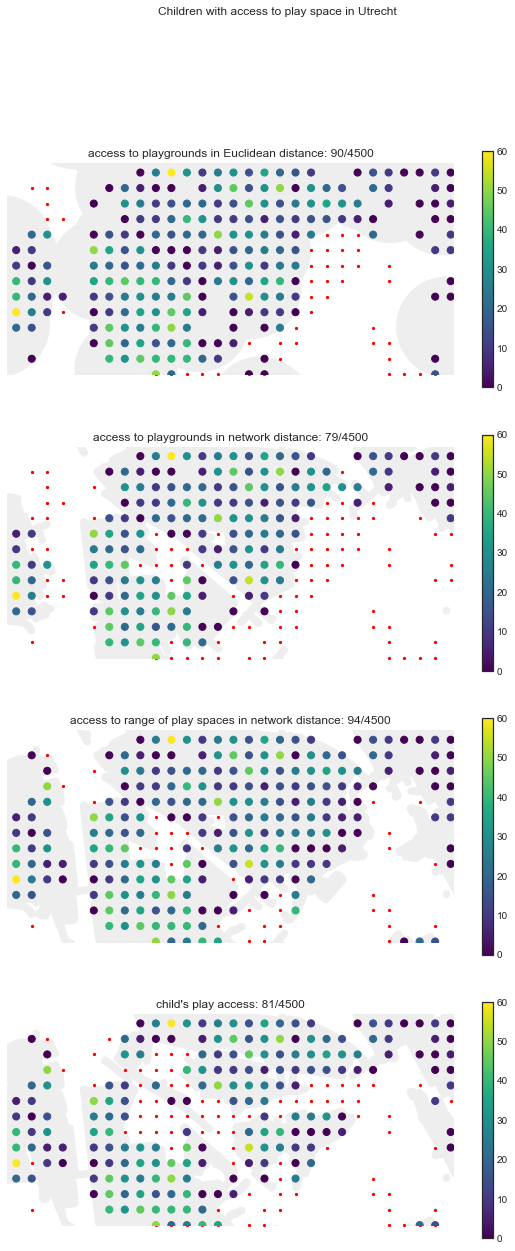

In [39]:
fig, axs = plt.subplots(figsize=(10,20), nrows=4, ncols=1)
fig.suptitle('Children with access to play space in Utrecht')

eucl_area.plot(ax=axs[0], color='#eeeeee')
population_utrecht.plot(ax=axs[0], color='red', markersize=5)
population_utrecht_eucl_access.plot(ax=axs[0], column=col_cld, cmap='viridis', markersize=50, legend=True)
axs[0].set_title('access to playgrounds in Euclidean distance: {}/{}'.format(cld_eucl_access_utrecht, cld_total_utrecht))

netw_area.plot(ax=axs[1], color='#eeeeee')
population_utrecht.plot(ax=axs[1], color='red', markersize=5)
population_utrecht_netw_access.plot(ax=axs[1], column=col_cld, cmap='viridis', markersize=50, legend=True)
axs[1].set_title('access to playgrounds in network distance: {}/{}'.format(cld_netw_access_utrecht, cld_total_utrecht))

range_area.plot(ax=axs[2], color='#eeeeee')
population_utrecht.plot(ax=axs[2], color='red', markersize=5)
population_utrecht_range_access.plot(ax=axs[2], column=col_cld, cmap='viridis', markersize=50, legend=True)
axs[2].set_title('access to range of play spaces in network distance: {}/{}'.format(cld_range_access_utrecht, cld_total_utrecht))

childsplay_area.plot(ax=axs[3], color='#eeeeee')
population_utrecht.plot(ax=axs[3], color='red', markersize=5)
population_utrecht_childsplay_access.plot(ax=axs[3], column=col_cld, cmap='viridis', markersize=50, legend=True)
axs[3].set_title('child\'s play access: {}/{}'.format(cld_childsplay_access_utrecht, cld_total_utrecht))

for ax in axs:
    ax.set_xlim(([place_utrecht.total_bounds[0], place_utrecht.total_bounds[2]]))
    ax.set_ylim(([place_utrecht.total_bounds[1], place_utrecht.total_bounds[3]]))
    ax.axis('off')

plt.show()

## Plot child's play metric for three cities

In [40]:
trip_labels = []
for trip_distance in trip_distances:
    trip_labels.append('Within {}m walk'.format(trip_distance))

In [41]:
trip_labels_independent = []
for trip_distance in trip_distances:
    trip_labels_independent.append('Within an independent {}m walk'.format(trip_distance))

In [42]:
color_barr = '#ffbe7a'  #fc8d59'
width_barr = 5
color_path = 'black'
width_path = 0.5
color_popu = 'grey'  #'#eeeeee'
size_popu = 50
alpha_popu =  0.25
size_popu = 1000

color_play = '#a270d1'
color_play_access = '#d0b7e8'

color_scho = '#7abbff'
color_scho_access = '#bcddff'

color_park = '#95cc61'
color_park_access = '#cae5b0'

alpha_access = 0.75

fontsize_main = 50
fontsize_sub = 40
fontsize_legend = 30

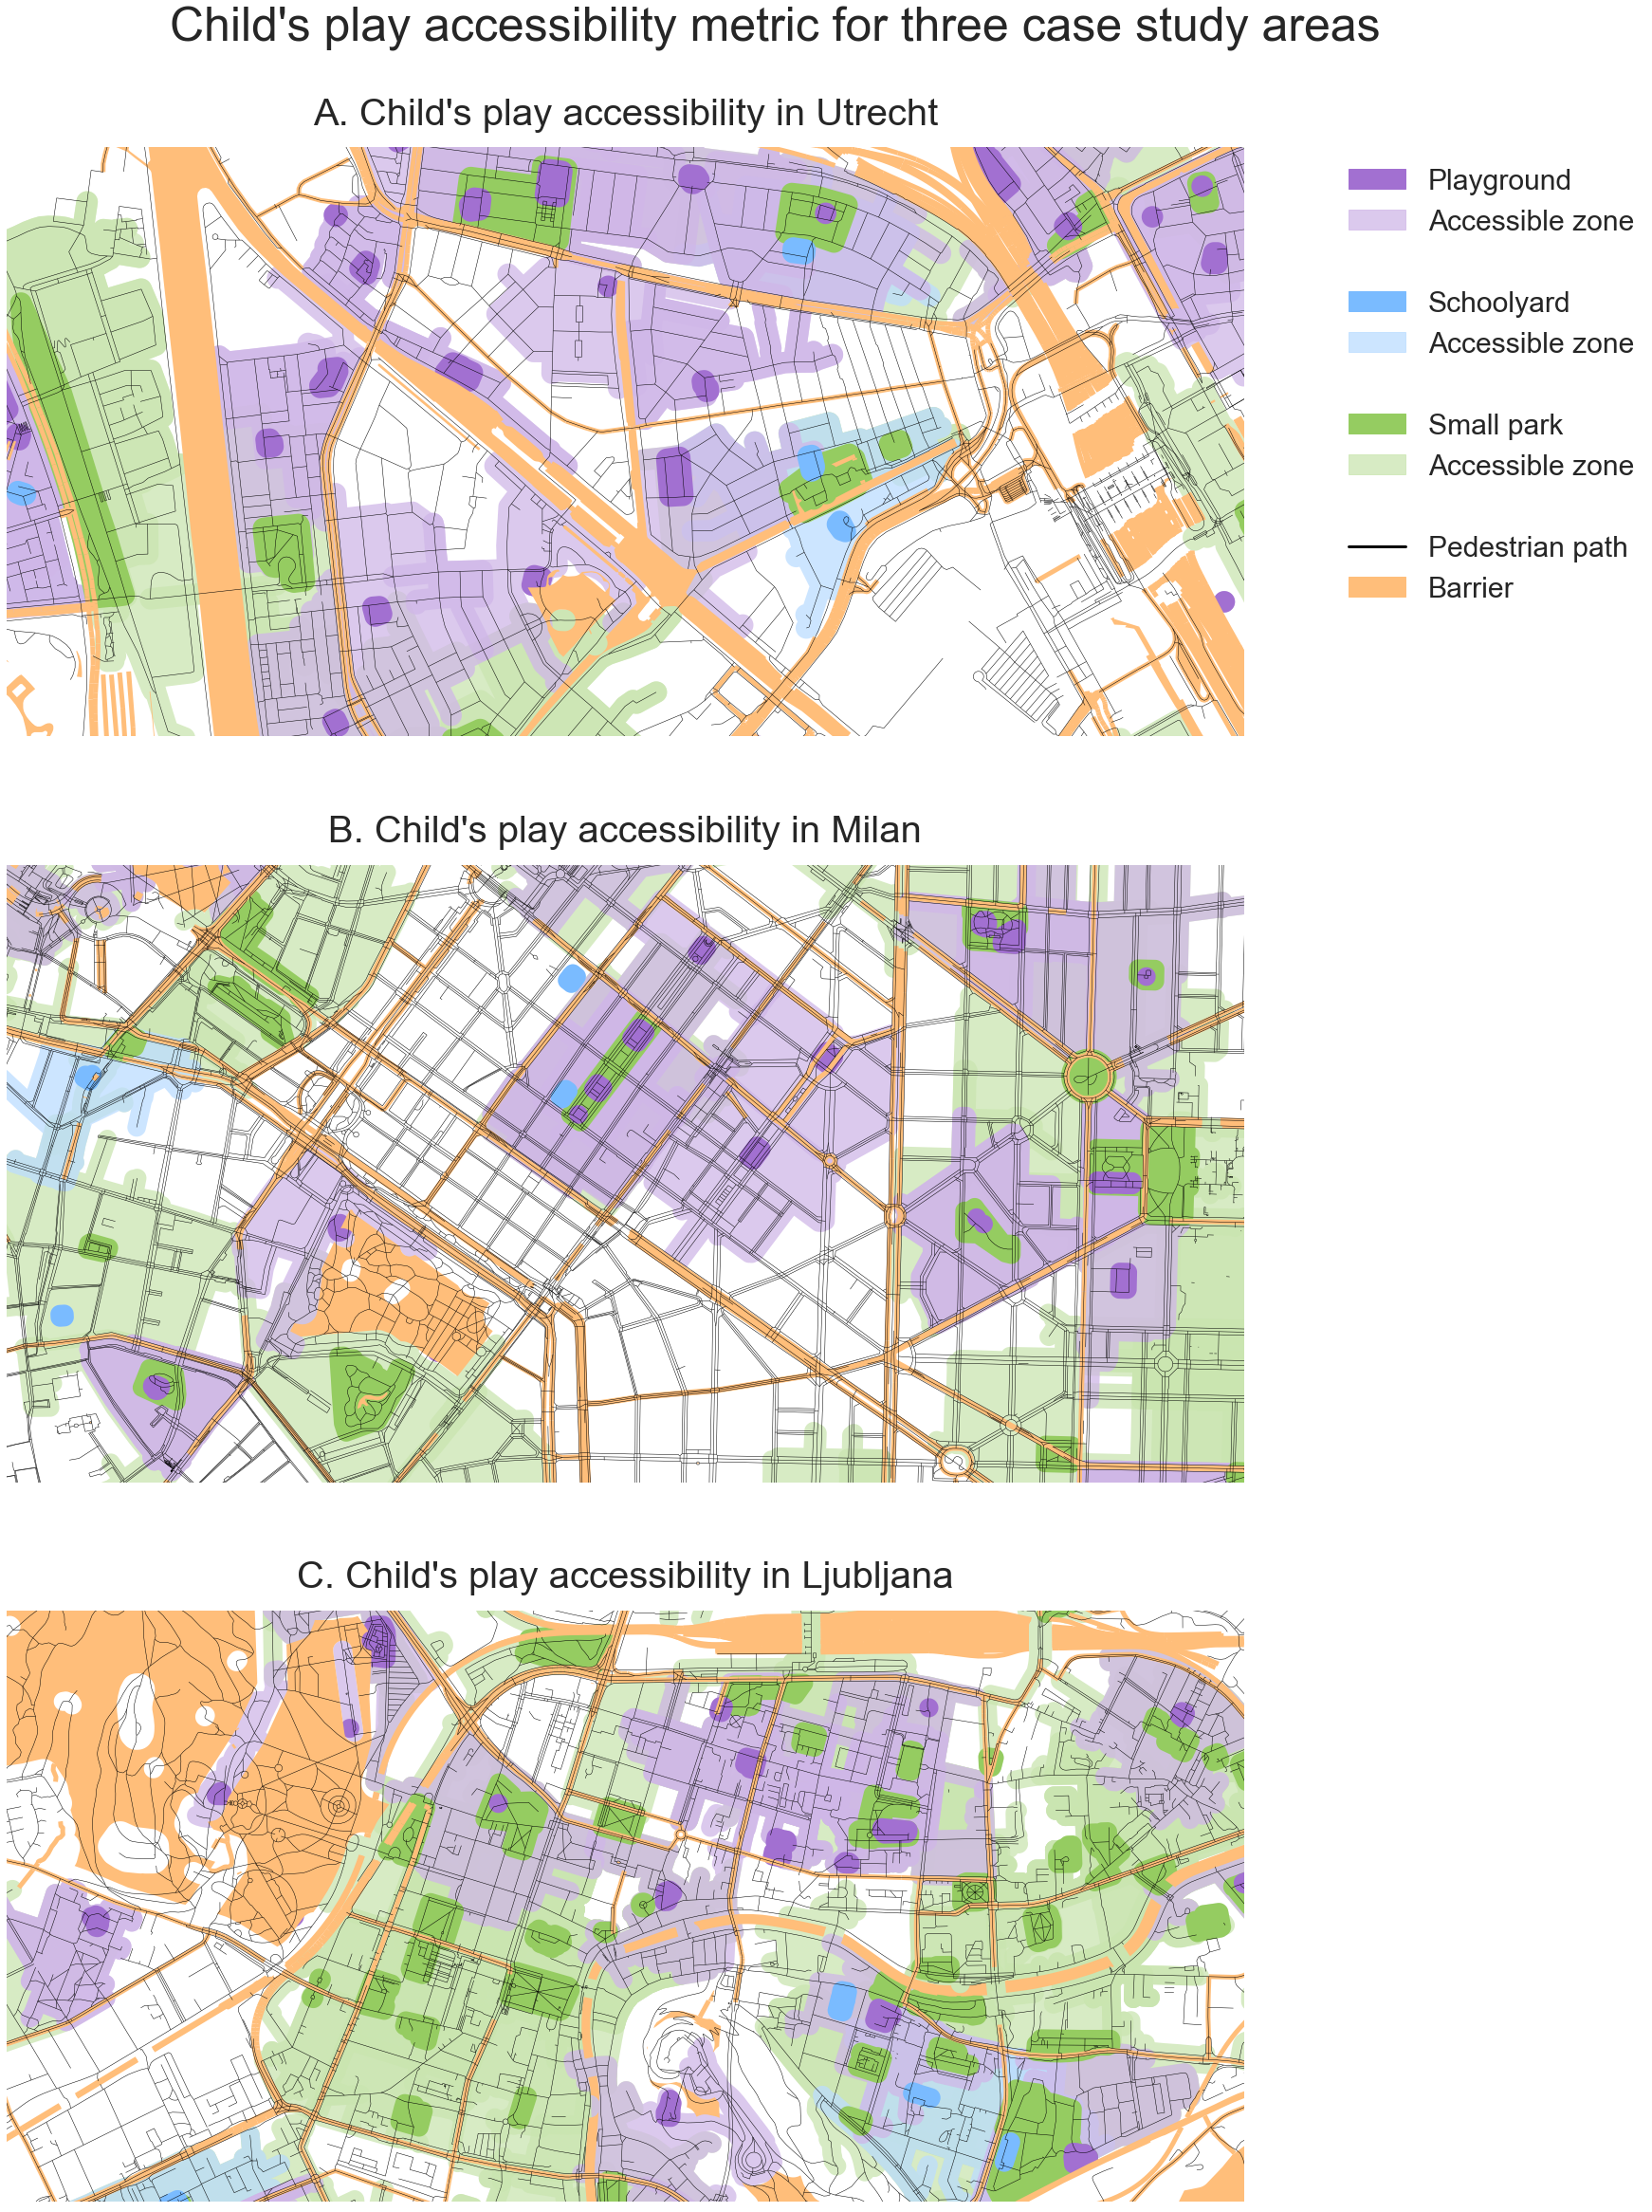

In [43]:
fig, axs = plt.subplots(figsize=(30,40))
fig.suptitle('Child\'s play accessibility metric for three case study areas', fontsize=fontsize_main, y=0.93)

# two columns
gs_total = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[6,1])
left = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_total[0], height_ratios=[0.96,1,0.96])
right = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_total[1])


# Utrecht
left0 = fig.add_subplot(left[0])
playground_childsplay_access_utrecht.set_geometry(('geom_iso_300')).plot(ax=left0, color=color_play_access, alpha=alpha_access, zorder=4)
schoolyard_childsplay_access_utrecht.set_geometry(('geom_iso_300')).plot(ax=left0, color=color_scho_access, alpha=alpha_access, zorder=3)
small_park_childsplay_access_utrecht.set_geometry(('geom_iso_300')).plot(ax=left0, color=color_park_access, alpha=alpha_access, zorder=2)
playground_childsplay_access_utrecht.plot(ax=left0, color=color_play, zorder=7)
schoolyard_childsplay_access_utrecht.plot(ax=left0, color=color_scho, zorder=6)
small_park_childsplay_access_utrecht.plot(ax=left0, color=color_park, zorder=5)
all_barriers_nosafecrossing_utrecht.plot(ax=left0, color=color_barr, linewidth=width_barr, zorder=8)
paths_utrecht.plot(ax=left0, color=color_path, linewidth=width_path, zorder=9)
left0.set_title('A. Child\'s play accessibility in Utrecht', fontsize=fontsize_sub, y=1.03)


# Milano
left1 = fig.add_subplot(left[1])
playground_childsplay_access_milano.set_geometry(('geom_iso_300')).plot(ax=left1, color=color_play_access, alpha=alpha_access, zorder=4)
schoolyard_childsplay_access_milano.set_geometry(('geom_iso_300')).plot(ax=left1, color=color_scho_access, alpha=alpha_access, zorder=3)
small_park_childsplay_access_milano.set_geometry(('geom_iso_300')).plot(ax=left1, color=color_park_access, alpha=alpha_access, zorder=2)
playground_childsplay_access_milano.plot(ax=left1, color=color_play, zorder=7)
schoolyard_childsplay_access_milano.plot(ax=left1, color=color_scho, zorder=6)
small_park_childsplay_access_milano.plot(ax=left1, color=color_park, zorder=5)
all_barriers_nosafecrossing_milano.plot(ax=left1, color=color_barr, linewidth=width_barr, zorder=8)
paths_milano.plot(ax=left1, color=color_path, linewidth=width_path, zorder=9)
left1.set_title('B. Child\'s play accessibility in Milan', fontsize=fontsize_sub, y=1.03)


# Ljubljana
left2 = fig.add_subplot(left[2])
playground_childsplay_access_ljubljana.set_geometry(('geom_iso_300')).plot(ax=left2, color=color_play_access, alpha=alpha_access, zorder=4)
schoolyard_childsplay_access_ljubljana.set_geometry(('geom_iso_300')).plot(ax=left2, color=color_scho_access, alpha=alpha_access, zorder=3)
small_park_childsplay_access_ljubljana.set_geometry(('geom_iso_300')).plot(ax=left2, color=color_park_access, alpha=alpha_access, zorder=2)
playground_childsplay_access_ljubljana.plot(ax=left2, color=color_play, zorder=7)
schoolyard_childsplay_access_ljubljana.plot(ax=left2, color=color_scho, zorder=6)
small_park_childsplay_access_ljubljana.plot(ax=left2, color=color_park, zorder=5)
all_barriers_nosafecrossing_ljubljana.plot(ax=left2, color=color_barr, linewidth=width_barr, zorder=8)
paths_ljubljana.plot(ax=left2, color=color_path, linewidth=width_path, zorder=9)
left2.set_title('C. Child\'s play accessibility in Ljubljana', fontsize=fontsize_sub, y=1.03)


# Legend, once
right0 = fig.add_subplot(right[0])
handles = [
    mpatches.Patch(color=color_play, label='Playground'),
    mpatches.Patch(color=color_play_access, alpha=alpha_access, label='Accessible zone'),
    mpatches.Patch(color='None'),
    mpatches.Patch(color=color_scho, label='Schoolyard'),
    mpatches.Patch(color=color_scho_access, alpha=alpha_access, label='Accessible zone'),
    mpatches.Patch(color='None'),
    mpatches.Patch(color=color_park, label='Small park'),
    mpatches.Patch(color=color_park_access, alpha=alpha_access, label='Accessible zone'),
    mpatches.Patch(color='None'),
    mlines.Line2D([], [], color=color_path, linewidth=3, label='Pedestrian path'), 
    mpatches.Patch(color=color_barr, label='Barrier')]
right0.legend(handles=handles, loc='upper center', fontsize=fontsize_legend)



left0.set_xlim(([place_utrecht.total_bounds[0], place_utrecht.total_bounds[2]]))
left0.set_ylim(([place_utrecht.total_bounds[1], place_utrecht.total_bounds[3]]))
left1.set_xlim(([place_milano.total_bounds[0], place_milano.total_bounds[2]]))
left1.set_ylim(([place_milano.total_bounds[1], place_milano.total_bounds[3]]))
left2.set_xlim(([place_ljubljana.total_bounds[0], place_ljubljana.total_bounds[2]]))
left2.set_ylim(([place_ljubljana.total_bounds[1], place_ljubljana.total_bounds[3]]))
    
gs_list = [left0, left1, left2, right0]
for gs in gs_list:
    gs.axis('off')
axs.axis('off')
    

plt.show()

## plot play-space access for children: baseline vs. child's play

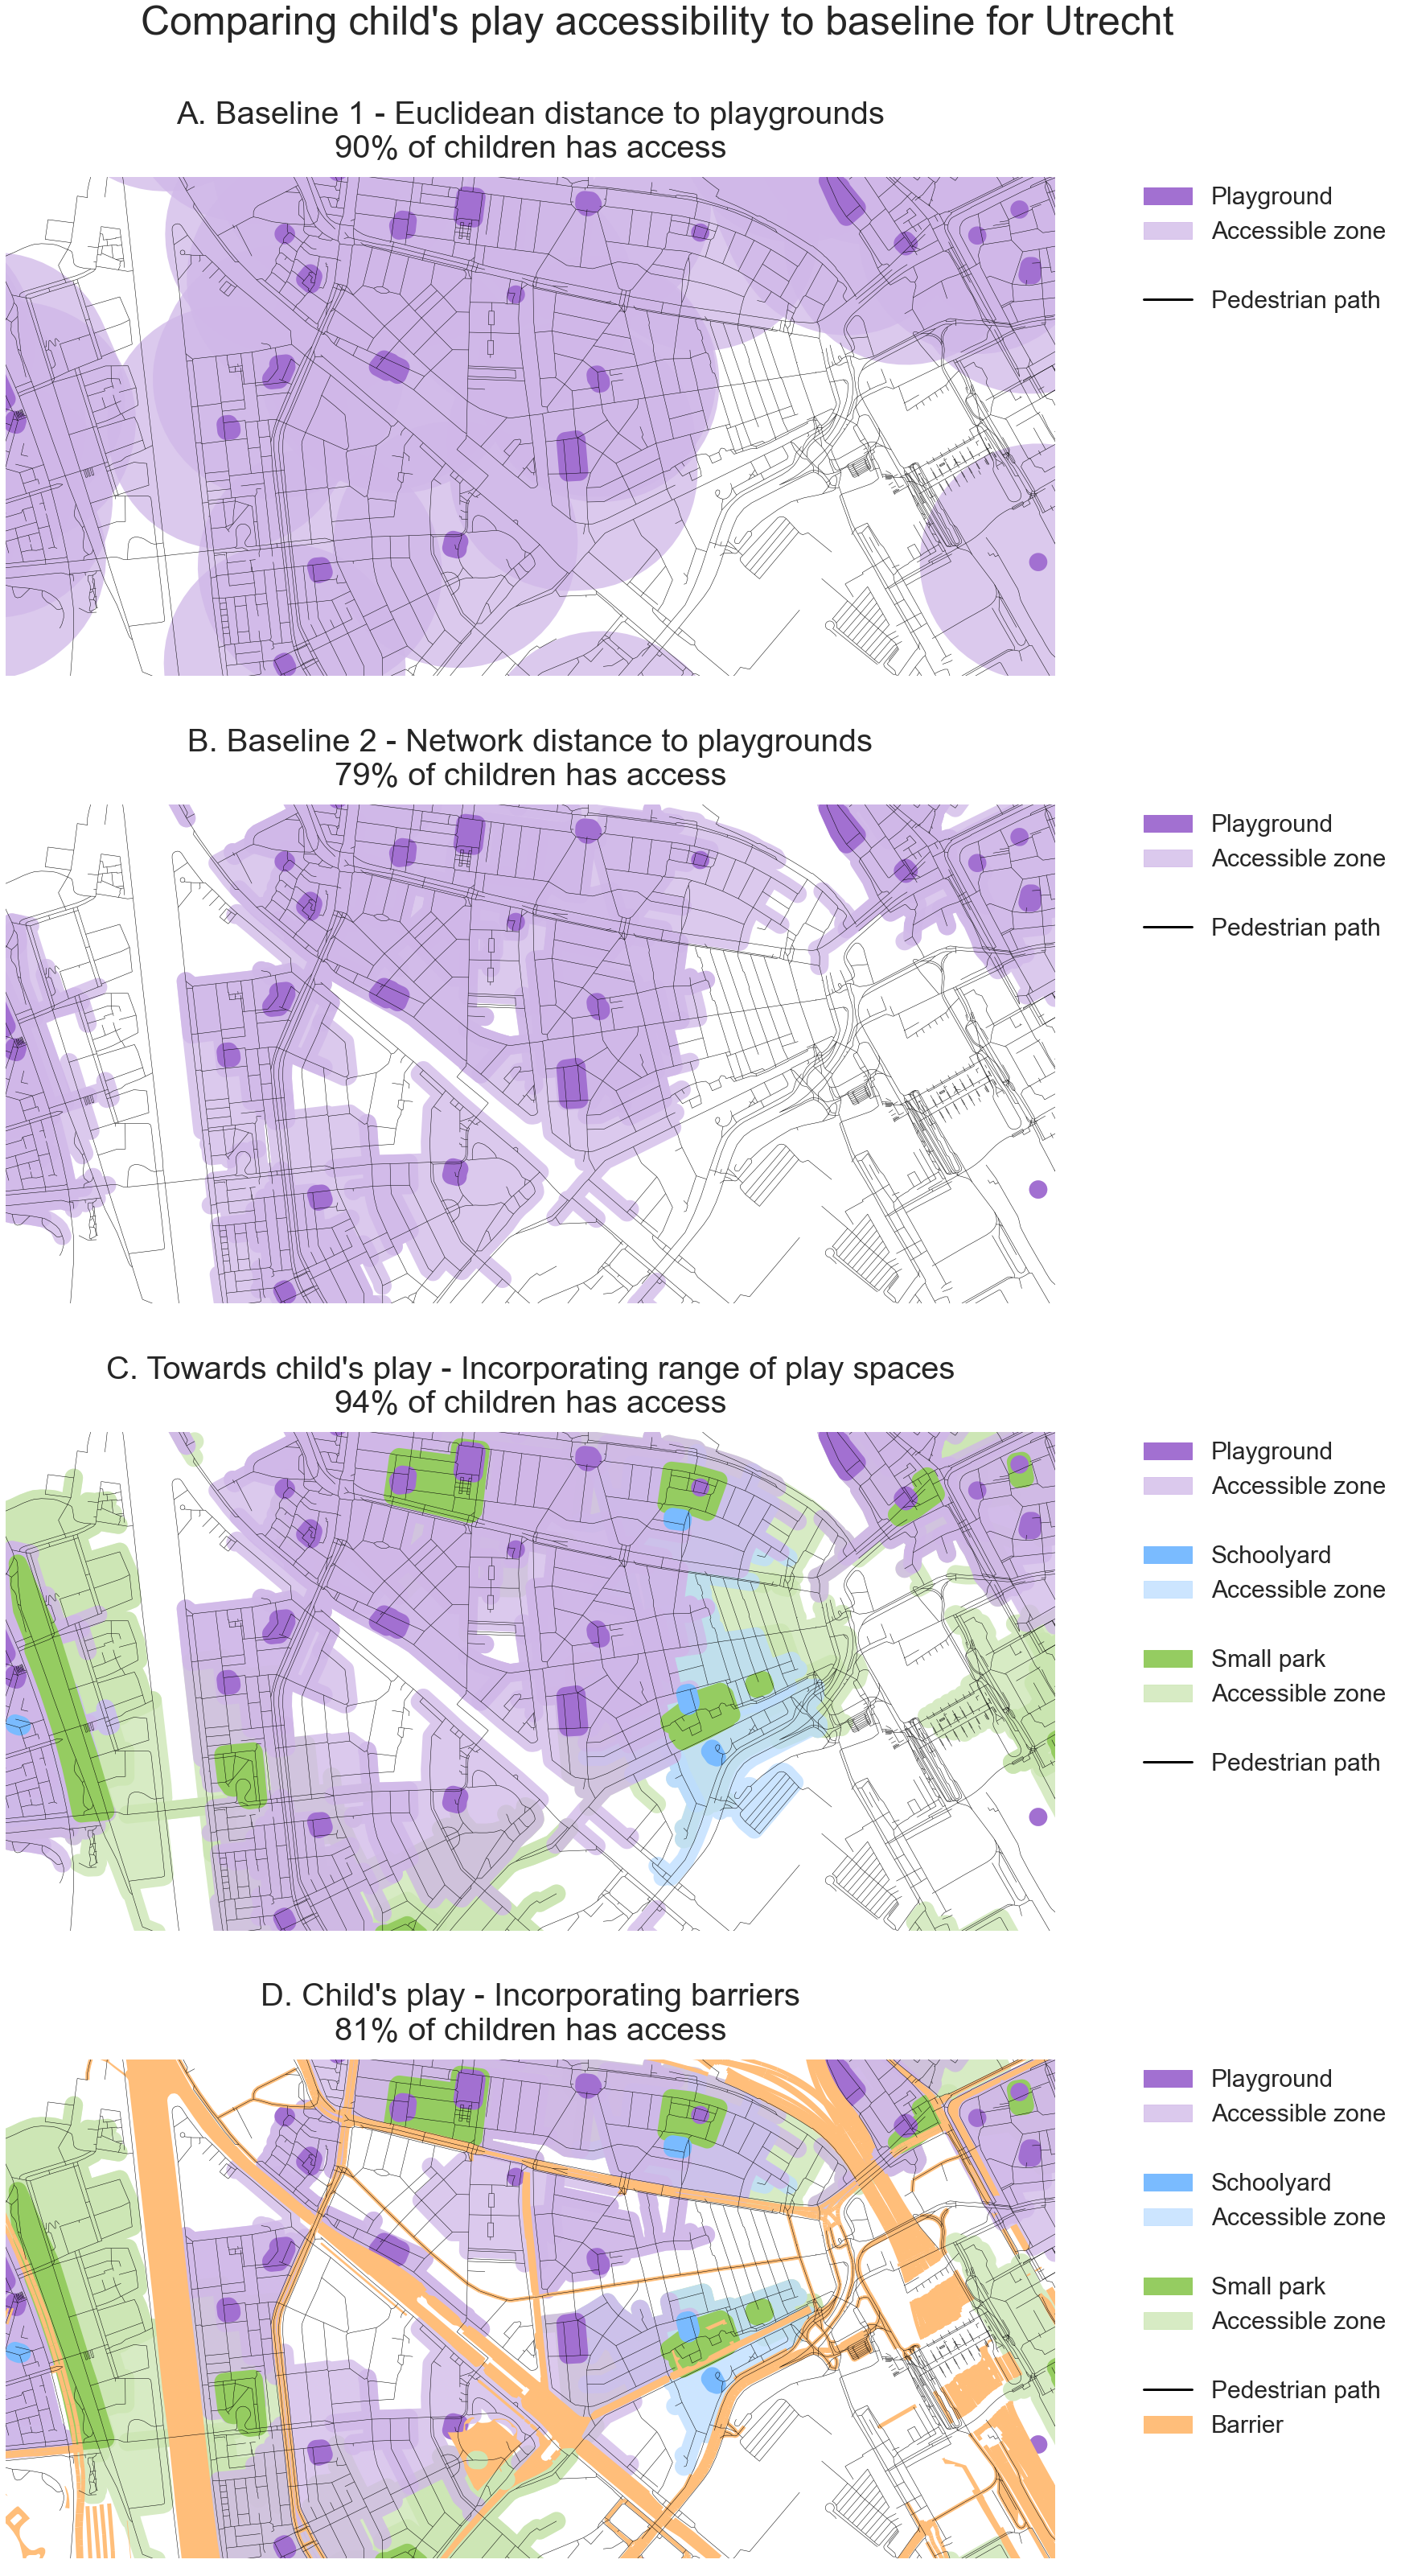

In [44]:
fig, axs = plt.subplots(figsize=(30,55))
fig.suptitle('Comparing child\'s play accessibility to baseline for Utrecht', fontsize=fontsize_main, y=0.93)

# two columns
gs_total = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[6,1])
left = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs_total[0])
right = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs_total[1])


# Euclidean to play
left0 = fig.add_subplot(left[0])
playground_euclidean_access_utrecht.set_geometry(('geom_eucl_300')).plot(ax=left0, color=color_play_access, alpha=alpha_access, zorder=4)
playground_euclidean_access_utrecht.plot(ax=left0, color=color_play, zorder=7)
paths_utrecht.plot(ax=left0, color=color_path, linewidth=width_path, zorder=9)
# population_utrecht[population_utrecht[col_cld]>0].plot(ax=left0, color=color_popu, alpha=alpha_popu, marker='s', markersize=size_popu, zorder=10)
left0.set_title('A. Baseline 1 - Euclidean distance to playgrounds\n{}% of children has access'.format(cld_eucl_access_utrecht), fontsize=fontsize_sub, y=1.03)
# legend
right0 = fig.add_subplot(right[0])
handles = [
    mpatches.Patch(color=color_play, label='Playground'),
    mpatches.Patch(color=color_play_access, alpha=alpha_access, label='Accessible zone'),
    mpatches.Patch(color='None'),
    mlines.Line2D([], [], color=color_path, linewidth=3, label='Pedestrian path')]
    # mlines.Line2D([], [], color=color_popu, marker='s', linestyle='None', markersize=30, alpha=alpha_popu, label='Populated by children')
right0.legend(handles=handles, loc='upper center', fontsize=fontsize_legend)

# Network to play
left1 = fig.add_subplot(left[1])
playground_network_access_utrecht.set_geometry(('geom_iso_300')).plot(ax=left1, color=color_play_access, alpha=alpha_access, zorder=4)
playground_network_access_utrecht.plot(ax=left1, color=color_play, zorder=7)
paths_utrecht.plot(ax=left1, color=color_path, linewidth=width_path, zorder=9)
# population_utrecht[population_utrecht[col_cld]>0].plot(ax=left1, color=color_popu, alpha=alpha_popu, marker='s', markersize=size_popu, zorder=10)
left1.set_title('B. Baseline 2 - Network distance to playgrounds\n{}% of children has access'.format(cld_netw_access_utrecht), fontsize=fontsize_sub, y=1.03)
# legend
right1 = fig.add_subplot(right[1])
handles = [
    mpatches.Patch(color=color_play, label='Playground'),
    mpatches.Patch(color=color_play_access, alpha=alpha_access, label='Accessible zone'),
    mpatches.Patch(color='None'),
    mlines.Line2D([], [], color=color_path, linewidth=3, label='Pedestrian path')]
    # mlines.Line2D([], [], color=color_popu, marker='s', linestyle='None', markersize=30, alpha=alpha_popu, label='Populated by children')
right1.legend(handles=handles, loc='upper center', fontsize=fontsize_legend)

# Network to range of spaces
left2 = fig.add_subplot(left[2])
playground_network_access_utrecht.set_geometry(('geom_iso_300')).plot(ax=left2, color=color_play_access, alpha=alpha_access, zorder=4)
schoolyard_network_access_utrecht.set_geometry(('geom_iso_300')).plot(ax=left2, color=color_scho_access, alpha=alpha_access, zorder=3)
small_park_network_access_utrecht.set_geometry(('geom_iso_300')).plot(ax=left2, color=color_park_access, alpha=alpha_access, zorder=2)
playground_network_access_utrecht.plot(ax=left2, color=color_play, zorder=7)
schoolyard_network_access_utrecht.plot(ax=left2, color=color_scho, zorder=6)
small_park_network_access_utrecht.plot(ax=left2, color=color_park, zorder=5)
paths_utrecht.plot(ax=left2, color=color_path, linewidth=width_path, zorder=9)
# population_utrecht[population_utrecht[col_cld]>0].plot(ax=left2, color=color_popu, alpha=alpha_popu, marker='s', markersize=size_popu, zorder=10)
left2.set_title('C. Towards child\'s play - Incorporating range of play spaces\n{}% of children has access'.format(cld_range_access_utrecht), fontsize=fontsize_sub, y=1.03)
# legend
right2 = fig.add_subplot(right[2])
handles = [
    mpatches.Patch(color=color_play, label='Playground'),
    mpatches.Patch(color=color_play_access, alpha=alpha_access, label='Accessible zone'),
    mpatches.Patch(color='None'),
    mpatches.Patch(color=color_scho, label='Schoolyard'),
    mpatches.Patch(color=color_scho_access, alpha=alpha_access, label='Accessible zone'),
    mpatches.Patch(color='None'),
    mpatches.Patch(color=color_park, label='Small park'),
    mpatches.Patch(color=color_park_access, alpha=alpha_access, label='Accessible zone'),
    mpatches.Patch(color='None'),
    mlines.Line2D([], [], color=color_path, linewidth=3, label='Pedestrian path')]
    # mlines.Line2D([], [], color=color_popu, marker='s', linestyle='None', markersize=30, alpha=alpha_popu, label='Populated by children')
right2.legend(handles=handles, loc='upper center', fontsize=fontsize_legend)


# Child's play
left3 = fig.add_subplot(left[3])
playground_childsplay_access_utrecht.set_geometry(('geom_iso_300')).plot(ax=left3, color=color_play_access, alpha=alpha_access, zorder=4)
schoolyard_childsplay_access_utrecht.set_geometry(('geom_iso_300')).plot(ax=left3, color=color_scho_access, alpha=alpha_access, zorder=3)
small_park_childsplay_access_utrecht.set_geometry(('geom_iso_300')).plot(ax=left3, color=color_park_access, alpha=alpha_access, zorder=2)
playground_childsplay_access_utrecht.plot(ax=left3, color=color_play, zorder=7)
schoolyard_childsplay_access_utrecht.plot(ax=left3, color=color_scho, zorder=6)
small_park_childsplay_access_utrecht.plot(ax=left3, color=color_park, zorder=5)
all_barriers_nosafecrossing_utrecht.plot(ax=left3, color=color_barr, linewidth=width_barr, zorder=8)
paths_utrecht.plot(ax=left3, color=color_path, linewidth=width_path, zorder=9)
# population_utrecht[population_utrecht[col_cld]>0].plot(ax=left3, color=color_popu, alpha=alpha_popu, marker='s', markersize=size_popu, zorder=10)
left3.set_title('D. Child\'s play - Incorporating barriers\n{}% of children has access'.format(cld_childsplay_access_utrecht), fontsize=fontsize_sub, y=1.03)
# legend
right3 = fig.add_subplot(right[3])
handles = [
    mpatches.Patch(color=color_play, label='Playground'),
    mpatches.Patch(color=color_play_access, alpha=alpha_access, label='Accessible zone'),
    mpatches.Patch(color='None'),
    mpatches.Patch(color=color_scho, label='Schoolyard'),
    mpatches.Patch(color=color_scho_access, alpha=alpha_access, label='Accessible zone'),
    mpatches.Patch(color='None'),
    mpatches.Patch(color=color_park, label='Small park'),
    mpatches.Patch(color=color_park_access, alpha=alpha_access, label='Accessible zone'),
    mpatches.Patch(color='None'),
    mlines.Line2D([], [], color=color_path, linewidth=3, label='Pedestrian path'), 
    mpatches.Patch(color=color_barr, label='Barrier')]
    # mlines.Line2D([], [], color=color_popu, marker='s', linestyle='None', markersize=30, alpha=alpha_popu, label='Populated by children')
right3.legend(handles=handles, loc='upper center', fontsize=fontsize_legend)






left_list = [left0, left1, left2, left3]
for gs in left_list:
    gs.set_xlim(([place_utrecht.total_bounds[0], place_utrecht.total_bounds[2]]))
    gs.set_ylim(([place_utrecht.total_bounds[1], place_utrecht.total_bounds[3]]))
    gs.axis('off')
    
right_list = [right0, right1, right2, right3]
for gs in right_list:
    gs.axis('off')
    
axs.axis('off')
    

plt.show()